In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [3]:
import numpy
def plot_synthetic_data_trial(ax, data, trial, title=None, xylabs=None, color='tab:blue'):
    title_size = 12
    label_size = 10
    x = jnp.arange(0, 1000) / 1000
    # for i in range(start,start+3):
    l = trial
    K = data.shape[1]
    # i = 3
        
    for k in range(K):
        if type(color) is str:
            ax.plot(x, data[:,k,l], color=color)
        elif type(color) is numpy.ndarray:
            ax.plot(x, data[:,k,l], color=color[k])
        else:
            raise ValueError
    if title is None:
        ax.set_title(f'Trial {trial}', size=title_size)
    ax.margins(0)

    if xylabs is None:
        ax.set_ylabel('Intensity', size = label_size)
        ax.set_xlabel('Time (sec)', size = label_size)
    elif len(xylabs) == 2:
        ax.set_xlabel(xylabs[0], size = label_size)
        ax.set_ylabel(xylabs[1], size = label_size)
    else:
        raise ValueError
    # plt.xlim([0,sample_length/fs])


In [4]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [5]:
num_iters = 50

# 100000 10000000 1000000000
scale_init = 1000000000 
lcfg_attrs = {}

mcfg_attrs = {'emiters': num_iters}
ocfg_attrs = {'obs_type': 'pp_relu'}

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-22']
# for res_path in res_paths:
#     clean_dir(res_path)

res_load_refac = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in res_load_refac])
alphas = sorted([r['cfg'].obs.alpha for r in res_load_refac])

alpha = 50
osel = {'alpha': alpha}
res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)
cfg = res_jax_refac[0]['cfg']

24 paths found meeting critera
Multiple results found.


In [6]:
from cohlib.jax.dists import sample_from_gamma, sample_obs
from cohlib.jax.observations import add0

ocfg = cfg.obs
lcfg = cfg.latent

In [7]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [8]:
def sample_ccn_rank1(rk, eigvec, eigval, K, L):
    """
    Generate L samples from K-dimensional multivariate complex 
    normal (circular symmetric). 'cov' must be psd Hermitian.

    Args:
        rk: jax random key
        cov: (K,K) array PSD Hermitian covariance matrix
        L: number of samples

    Returns:
        samples: (K,L) array (complex)
    
    """
    eigvecs = jnp.zeros((K,K), dtype=complex)
    eigvecs = eigvecs.at[:,0].set(eigvec)

    eigvals = jnp.zeros(K)
    eigvals = eigvals.at[0].set(eigval)

    D = jnp.diag(jnp.sqrt(eigvals))
    A = eigvecs @ D

    unit_samples = jr.normal(rk, (K,L), dtype=complex)
    samples = jnp.einsum('ki,il->kl', A, unit_samples)

    return samples


In [9]:
L = 25
lcfg.L = L

In [10]:
N = 500
nz = jnp.array([9])
seed = 7

def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

alpha = 25
K = 10
J = 1
scale_target = 3 * 1e4
scale_gamma = 1e3
alphas = jnp.ones(K)*alpha
target_freq_ind = 9

phases = jr.uniform(jr.key(seed), (K,), minval=-jnp.pi, maxval=jnp.pi)
reals = jnp.cos(phases)
imags = jnp.sin(phases)

eigvec_target = reals + 1j*imags
eigvec_target = eigvec_target / jnp.linalg.norm(eigvec_target)
eigval_target = K*scale_target*scale_gamma
# eigval_target = (150)*scale_target*scale_gamma


lrk = jr.key(lcfg.seed)
zs_target = sample_ccn_rank1(lrk, eigvec_target, eigval_target, K, lcfg.L)

# gamma = gamma[:,:2,:2]
# alphas = alphas[:2]


gamma = jnp.zeros((N,K,K), dtype=complex)
zs = sample_from_gamma(lrk, gamma, lcfg.L)
zs = zs.at[target_freq_ind,:,:].set(zs_target)

gamma_target = eigval_target * jnp.einsum('i,j->ij', eigvec_target, eigvec_target.conj()) 
real_diag = jnp.diag(gamma_target).real
gamma_target = gamma_target.at[jnp.eye(K).astype(bool)].set(real_diag)

gamma = gamma.at[target_freq_ind,:,:].set(gamma_target)

zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)
lams = cif_alpha_relu(alphas, xs)

ocfg.alpha = alpha
obs, obs_params = sample_obs(ocfg, xs)
obs_type = ocfg.obs_type

In [11]:
jnp.stack([eigvec_target for _ in range(3)]).shape

(3, 10)

In [12]:
eva, eve = jnp.linalg.eigh(gamma[9])

In [13]:
recomp = eve @ jnp.diag(eva) @ eve.conj().T

In [14]:
eve_trim = jnp.zeros_like(eve)
eve_1 = jnp.zeros_like(eve)
eve_trim = eve_trim.at[:,-1].set(eve[:,-1])
eva_trim = jnp.zeros_like(eva)
eva_1 = jnp.zeros_like(eva)
eva_trim = eva_trim.at[-1].set(eva[-1])

In [15]:
recomp2 =  eve_trim @ jnp.diag(eva_trim) @ eve_trim.T.conj()
# jnp.all(jnp.isclose(gamma[9], recomp2))
jnp.all(jnp.isclose(recomp, recomp2))

Array(True, dtype=bool)

In [16]:
test_evals = jnp.array([eigval_target, 1, 2])
rank = test_evals.size
test_evecs = jnp.stack([eigvec_target for _ in range(rank)]).swapaxes(0,1)
eigvals = jnp.zeros(K)
eigvals = jnp.diag(eigvals.at[:rank].set(test_evals))

In [17]:
U_blank = jnp.zeros((K, K), dtype=complex)
U = U_blank.copy()
U = U.at[:,:rank].set(test_evecs)

In [18]:
test_evecs.shape

(10, 3)

In [19]:
recomp3 = U @ eigvals @ U.T.conj()

In [20]:
jnp.isclose(gamma[9], recomp3)

Array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]], dtype=bool)

In [21]:
gamma_target.shape

(10, 10)

Text(0.5, 1.0, '$\\alpha$=25; $n^{0,\\ell}$')

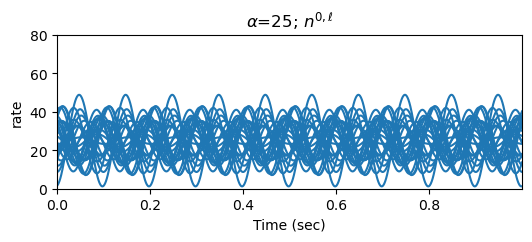

In [22]:
Ks_plot = jnp.array([0])
lams_plot = lams[:,Ks_plot,:]
obs_plot = obs[:,Ks_plot,:]

fig,ax = plt.subplots(figsize=(6,2))
for trial in range(L):
    plot_synthetic_data_trial(ax, lams_plot, trial, 
     xylabs=['Time (sec)', 'rate'])
ax.set_ylim([0,80])
ax.set_title(r'$\alpha$=' f'{alpha}; ' + '$n^{0,\ell}$')

In [23]:
lams.shape

(1000, 10, 25)

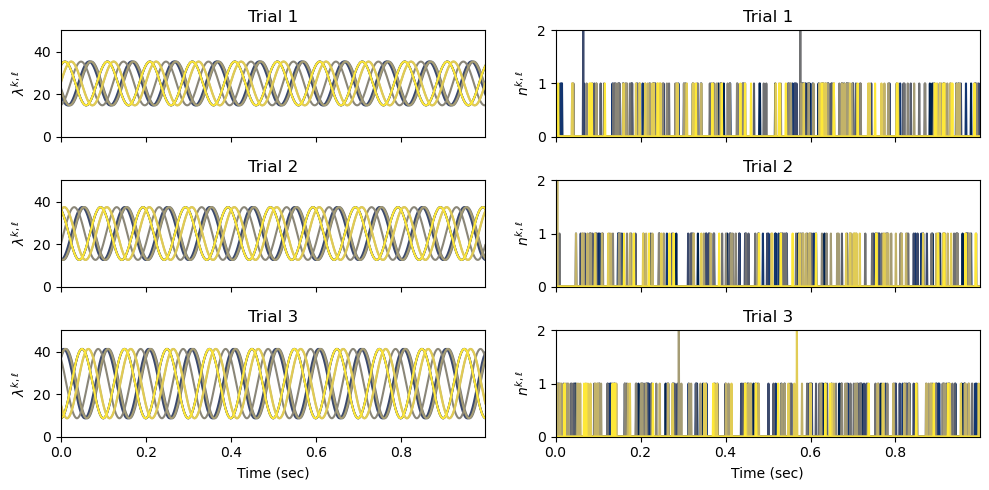

In [24]:
# Ks_plot = jnp.array([0,5,10,15])
fig,ax = plt.subplots(3,2,figsize=(10,5), sharex=True)
trials = jnp.arange(3)+1

colors = plt.cm.cividis(jnp.linspace(0,1,K))
for i, trial in enumerate(trials):
    if trial == trials[-1]:
        xlab='Time (sec)'
    else:
        xlab=''

    plot_synthetic_data_trial(ax[i,0], lams, trial, color=colors, xylabs=[xlab, '$\\lambda^{k,\ell}$'])
    ax[i,0].set_ylim([0,50])
    plot_synthetic_data_trial(ax[i,1], obs, trial, color=colors, xylabs=[xlab, '$n^{k,\ell}$'])
plt.tight_layout()
plt.show()


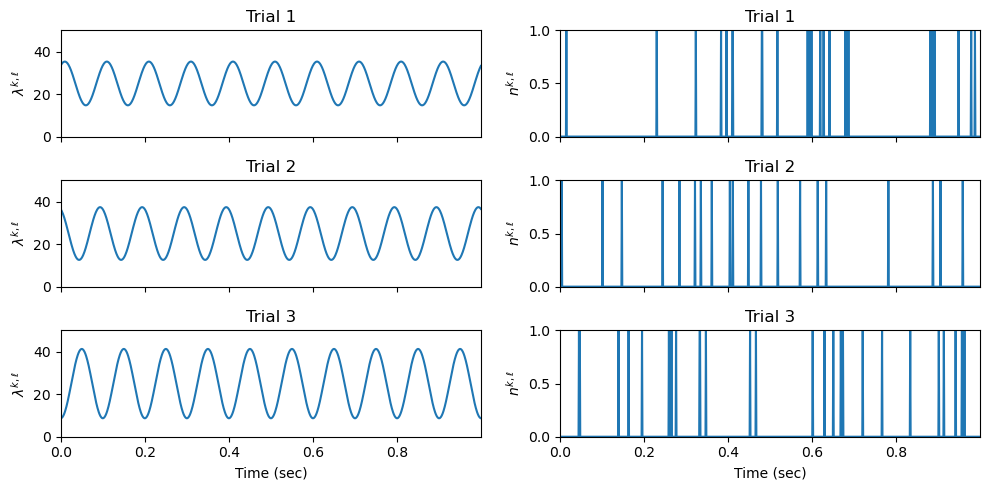

In [25]:
# Ks_plot = jnp.array([0,5,10,15])
fig,ax = plt.subplots(3,2,figsize=(10,5), sharex=True)
trials = jnp.arange(3)+1

K_plot = jnp.array([0])
lams_plot = lams[:,K_plot,:]
obs_plot = obs[:,K_plot,:]

colors = plt.cm.cividis(jnp.linspace(0,1,K))
for i, trial in enumerate(trials):
    if trial == trials[-1]:
        xlab='Time (sec)'
    else:
        xlab=''

    plot_synthetic_data_trial(ax[i,0], lams_plot, trial, xylabs=[xlab, '$\\lambda^{k,\ell}$'])
    ax[i,0].set_ylim([0,50])
    plot_synthetic_data_trial(ax[i,1], obs_plot, trial, xylabs=[xlab, '$n^{k,\ell}$'])
plt.tight_layout()
plt.show()


In [26]:
gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz,:,:], zs[nz,:,:].conj()).mean(-1)

In [27]:
from cohlib.jax.dists import naive_estimator
nz_model = nz
naive_est = naive_estimator(obs, nz_model) 

In [28]:
k = 3
print(naive_est[:,k,k].real)
print(gamma[9,k,k] * 1e-6)
print(gamma_oracle[:,k,k].real * 1e-6)

[56.057426]
(29.999998+0j)
[40.09174]


In [29]:
print(jnp.diag(naive_est[0,:,:].real).mean())
print(jnp.diag(gamma[9,:,:].real).mean() * 1e-6)
print(jnp.diag(gamma_oracle[0,:,:].real).mean() * 1e-6)

68.129845
30.0
40.09174


In [30]:
print(jnp.diag(naive_est[0,:,:].real).mean() * 1e6)
print(jnp.diag(gamma[9,:,:].real).mean())
print(jnp.diag(gamma_oracle[0,:,:].real).mean())

68129850.0
30000000.0
40091740.0


In [31]:
from cohlib.utils import pickle_save, gamma_root
freqs = jnp.arange(500)
nonzero_inds = nz 
target_inds = jnp.array([target_freq_ind])
save_path = os.path.join(gamma_root(), f'k{K}-chlg3-rank1-nz9.pkl')
save_dict = {'gamma': gamma, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 
             'target_inds': target_inds, 'eigvec': eigvec_target, 'eigval': eigval_target}
pickle_save(save_dict, save_path)

In [32]:
eigvec_target.shape

(10,)

In [33]:
# from cohlib.utils import pickle_save, gamma_root
# freqs = jnp.arange(500)
# nonzero_inds = nz 
# target_inds = jnp.array([target_freq_ind])
# save_path = os.path.join(gamma_root(), f'k{K}-chlg3-rank1-nz9.pkl')
# save_dict = {'gamma': gamma, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 
#              'target_inds': target_inds, 'eigvec': eigvec_target, 'eigval': eigval_target}
# pickle_save(save_dict, save_path)


In [34]:
from cohlib.utils import pickle_save, gamma_root
freqs = jnp.arange(500)
nonzero_inds = nz 
target_inds = jnp.array([target_freq_ind])
for K in [3, 10, 25, 50, 100]:
    J = 1
    scale_target = 3 * 1e4
    scale_gamma = 1e3
    alphas = jnp.ones(K)*alpha
    target_freq_ind = 9

    phases = jr.uniform(jr.key(seed), (K,), minval=-jnp.pi, maxval=jnp.pi)
    reals = jnp.cos(phases)
    imags = jnp.sin(phases)

    eigvec_target = reals + 1j*imags
    eigvec_target = eigvec_target / jnp.linalg.norm(eigvec_target)
    eigval_target = K*scale_target*scale_gamma

    gamma_nz = jnp.zeros((J,K,K))
    gamma = jnp.zeros((N,K,K), dtype=complex)
    gamma = gamma.at[nz,:,:].set(gamma_nz)
    gamma = gamma*scale_gamma

    gamma_target = eigval_target * jnp.einsum('i,j->ij', eigvec_target, eigvec_target.conj()) 
    real_diag = jnp.diag(gamma_target).real
    gamma_target = gamma_target.at[jnp.eye(K).astype(bool)].set(real_diag)

    gamma = gamma.at[target_freq_ind,:,:].set(gamma_target)

    eigvals = jnp.zeros((nonzero_inds.size, 1))
    eigvecs = jnp.zeros((nonzero_inds.size, K, 1), dtype=complex)
    eigvals = eigvals.at[0,0].set(eigval_target)
    eigvecs = eigvecs.at[0,:,0].set(eigvec_target)

    save_path = os.path.join(gamma_root(), f'k{K}-chlg3-relu-rank1-nz9.pkl')
    save_dict = {'gamma': gamma, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 
                'target_inds': target_inds, 'eigvecs': eigvecs, 'eigvals': eigvals}
    pickle_save(save_dict, save_path)

In [35]:
test1 = eigval_target * jnp.einsum('i,j->ij', eigvec_target, eigvec_target.conj()) 
test2 = eigval_target * jnp.outer(eigvec_target, eigvec_target.conj()) 

In [36]:
test1 == test2

Array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], dtype=bool)